# Using BERT to Identify Bill Hardy (Binary Classification)

## Classification of the Pages

Now that K-means clustering seems to indicate that some of the narrators can be inferred from the pages, we can attempt to use a language model to predict whether a page belongs to a given narrator. 

Let's start with a binary classification to **predict if sentences belong or not to Bill Hardy**.

<img src="https://glthr.com/cj/characters/bill-min.jpg" alt="drawing" width="400"/>

In [1]:
%%capture

# make logs less verbose
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# suppress UnparsedFlagAccessError warning
import sys
from absl import flags

sys.argv = ["preserve_unused_tokens=False"]
flags.FLAGS(sys.argv)

# suppress warnings
# (after having ensured they did not impact the analysis)
import warnings

warnings.filterwarnings("ignore")

## Process data

In [2]:
import pandas as pd

df = pd.read_json("./data/jawbone.json")

Augment the data with the label: `True` for Bill Hardy, `False` otherwise.

In [3]:
import json

f = open("./data/unofficial_solution.json")
possible_solutions = json.load(f)
f.close()


def is_bill(id):
    for key, ids in possible_solutions.items():
        if id in ids:
            return key == "Bill Hardy"
    return None


df = df.astype({"text": "string"})
df["is_Bill"] = df["page"].apply(lambda x: is_bill(x))
df

,page,text,is_Bill
0,1,I sit down alone at the appointed table and ta...,True
1,2,I plunged for the last time. The few remaining...,False
2,3,"At my meeting with Clement yesterday, he had b...",False
3,4,And I really think I would have preferred the ...,True
4,5,I hated my eye for being caught by what didn’t...,False
...,...,...,...
95,96,Now I think I will try a cup of what they inso...,True
96,97,To have slept and to wake right up surrounded ...,False
97,98,He stood and looked down at me; but I was not ...,False
98,99,"And she wore a mauve love-knot on her breast, ...",False


## Train BERT Model

In [4]:
import torch

# hyperparameters

num_epochs = 20
learning_rate = 2e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import logging

logging.set_verbosity_error()  # suppress untrained weight error (unconsequential)

# use BERT large uncased model
# https://huggingface.co/bert-large-uncased
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=1
)

In [6]:
from sklearn.model_selection import train_test_split


def get_datasets(df):
    # sample 40% of the Bill pages/sentences and more than 25% of all pages/sentences
    df_bill = df[df["is_Bill"] == True].sample(frac=0.3)
    df_not_bill = df[df["is_Bill"] == False].sample(frac=0.3)

    df_sampled = pd.concat([df_bill, df_not_bill], axis=0)

    print(df_sampled)

    # split datasets
    return train_test_split(
        df_sampled["text"].values,
        df_sampled["is_Bill"].values,
        test_size=0.2,
        random_state=42,
    )


train_texts, test_texts, train_labels, test_labels = get_datasets(df)

print(f"Train dataset size: {train_texts.shape[0]}")
print(f"Test dataset size: {test_texts.shape[0]}")

    page                                               text  is_Bill
46    47  Babs now moves across the vision, crowned with...     True
0      1  I sit down alone at the appointed table and ta...     True
62    63  I cannot help, even with this supreme distract...     True
29    30  I see that old dandy has purchased Cape Jasmin...     True
30    31  The others did not seem similarly impressed. P...    False
78    79  It was that day my friend Sandy told me he was...    False
91    92  My earlier days had been so different. There h...    False
66    67  the darker works of Beardsley and Felicien Rop...    False
80    81  The victim, for that I must now reluctantly ca...    False
14    15  Now, I considered, in my dear Lyons it would b...    False
34    35  For this time being, Henry was drawing towards...    False
84    85  I was true to time. I had, it occurred to me, ...    False
38    39  She said it didn’t matter what they had done, ...    False
98    99  And she wore a mauve lov

In [7]:
from torch.utils.data import DataLoader, Dataset


# tokenize and prepare the input data
class TokenizedData(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = float(self.labels[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.float32),
        }


# important: set a large max_len for the pages
train_dataloader = DataLoader(
    TokenizedData(train_texts, train_labels, tokenizer, max_len=512),
    batch_size=2,
    shuffle=True,
)
test_dataloader = DataLoader(
    TokenizedData(test_texts, test_labels, tokenizer, max_len=512),
    batch_size=2,
    shuffle=False,
)

In [8]:
from transformers import AdamW
import copy


def train(dataloader):
    model = copy.copy(bert_model)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].squeeze().to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits.flatten(), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"{epoch + 1}/{num_epochs} — loss: {avg_loss:.4f}")

    return model


model = train(train_dataloader)

1/20 — loss: 0.5752
2/20 — loss: 0.4729
3/20 — loss: 0.4083
4/20 — loss: 0.3292
5/20 — loss: 0.2131
6/20 — loss: 0.1890
7/20 — loss: 0.1348
8/20 — loss: 0.0926
9/20 — loss: 0.0526
10/20 — loss: 0.0269
11/20 — loss: 0.0151
12/20 — loss: 0.0105
13/20 — loss: 0.0090
14/20 — loss: 0.0075
15/20 — loss: 0.0069
16/20 — loss: 0.0061
17/20 — loss: 0.0053
18/20 — loss: 0.0049
19/20 — loss: 0.0047
20/20 — loss: 0.0043


## Predict

In [9]:
from sklearn.metrics import accuracy_score


def eval(model, texts):
    model.eval()

    inputs = tokenizer(
        [text for text in texts],
        return_tensors="pt",
        truncation=True,
        padding=True,
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    probabilities = torch.sigmoid(outputs.logits).cpu().numpy()
    predicted_labels = (probabilities > 0.5).astype(int)

    return predicted_labels


predictions = eval(model, test_texts)
accuracy = accuracy_score(test_labels, predictions)
print(f"Validation accuracy: {accuracy:.4f}")

Validation accuracy: 1.0000


In [10]:
predicted_labels = eval(model, df.text.values)

Confusion matrix

<Figure size 800x600 with 0 Axes>

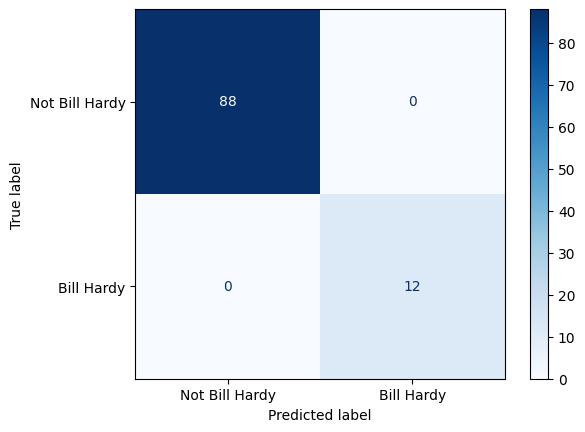

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def generate_confusion_matrix(model, df, predicted_labels):
    cm = confusion_matrix(df.is_Bill.values, predicted_labels)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Not Bill Hardy", "Bill Hardy"]
    )

    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues")

    plt.show()


generate_confusion_matrix(model, df, predicted_labels)

Identify misclassified pages

In [12]:
def identify_misclassified_items(df, predicted_labels, item_type):
    misclassified_indices = [
        i
        for i, (true, pred) in enumerate(zip(df.is_Bill.values, predicted_labels))
        if true != pred
    ]

    if len(misclassified_indices) == 0:
        print(f"No misclassified {item_type}")
        return

    print(f"Misclassified {item_type}:")
    for index in misclassified_indices:
        print(
            f"Expected narrator: {int(df.is_Bill.values[index])} — predicted narrator: {predicted_labels[index][0]} — [{df.page.values[index]}] {df.text.values[index]}"
        )


identify_misclassified_items(df, predicted_labels, "pages")

No misclassified pages


# Predicted Pages Representation

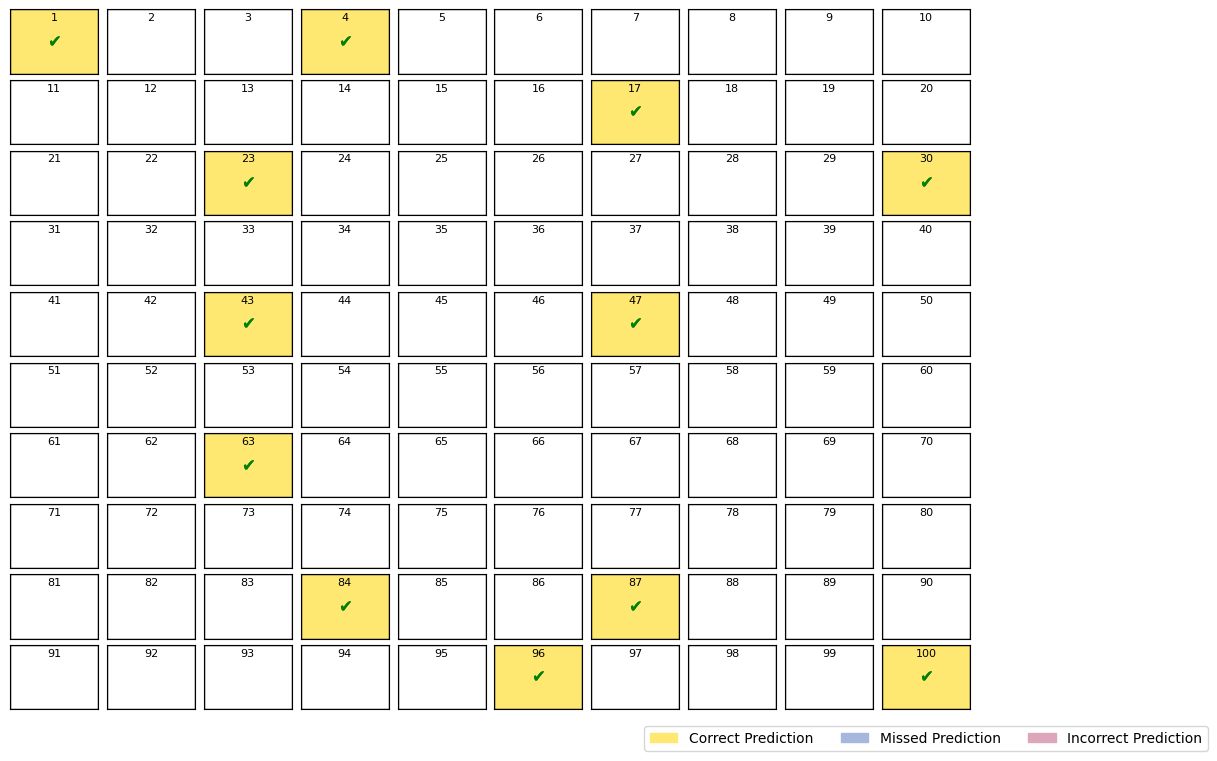

In [13]:
import matplotlib.patches as mpatches

cols, rows = 10, 10

expected_pages = [page - 1 for page in df[df["is_Bill"]]["page"].values.tolist()]
predicted_pages = [
    index for index, value in enumerate(predicted_labels.flatten()) if value == 1
]

fig, axs = plt.subplots(rows, cols, figsize=(cols, rows), tight_layout=True)

for i, ax in enumerate(axs.ravel()):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.add_patch(
        plt.Rectangle((0, 0), 1, 1, fill=True, edgecolor="#000000", facecolor="#FFFFFF")
    )
    row, col = divmod(i, cols)
    ax.text(0.5, 0.95, str(i + 1), ha="center", va="top", color="#000000", fontsize=8)

common_indices = set.intersection(set(expected_pages), set(predicted_pages))

for index in expected_pages + predicted_pages:
    row, col = divmod(index, cols)

    if index in common_indices:
        # pages adequately predicted
        axs[row, col].patches[0].set_facecolor("#FFE871")
        axs[row, col].text(
            0.5, 0.5, "✔", ha="center", va="center", color="green", fontsize=12
        )
    elif index in expected_pages:
        # pages erroneously not predicted
        axs[row, col].patches[0].set_facecolor("#A6B7DE")
        axs[row, col].text(
            0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
        )
    else:
        # pages erroneously predicted
        axs[row, col].patches[0].set_facecolor("#DEA6BA")
        axs[row, col].text(
            0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
        )

plt.legend(
    handles=[
        mpatches.Patch(color="#FFE871", label="Correct Prediction"),
        mpatches.Patch(color="#A6B7DE", label="Missed Prediction"),
        mpatches.Patch(color="#DEA6BA", label="Incorrect Prediction"),
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    ncol=3,
)

fig.set_size_inches(12, 10)
plt.subplots_adjust(top=0.9, bottom=0.2, left=0.1, right=0.9, hspace=0.1, wspace=0.1)

plt.show()

***

## Classification of the Sentences

In [14]:
# tokenize pages
from nltk import sent_tokenize


def tokenize_sentences(paragraph):
    sentences = sent_tokenize(paragraph)

    valid_sentences = [
        sentence for sentence in sentences if any(c.isalnum() for c in sentence)
    ]
    return valid_sentences


df["text"] = df["text"].apply(tokenize_sentences)
df = df.explode("text").reset_index(drop=True)
df

,page,text,is_Bill
0,1,I sit down alone at the appointed table and ta...,True
1,1,"Call me nervous, call me fey, if you will; at ...",True
2,1,It has not had much work since it flew so nimb...,True
3,1,"As I watch the sea, Casy Ferris passes with do...",True
4,1,"Of course, to-day is the day.",True
...,...,...,...
1225,100,O beastly woman.,True
1226,100,"You know not how ill’s all here, about my hear...",True
1227,100,"Henry, I feel it, is for the first and last ti...",True
1228,100,"Good-bye, Henry.",True


In [15]:
train_texts, test_texts, train_labels, test_labels = get_datasets(df)

print(f"Train dataset size: {train_texts.shape[0]}")
print(f"Test dataset size: {test_texts.shape[0]}")

train_dataloader = DataLoader(
    TokenizedData(train_texts, train_labels, tokenizer), batch_size=20, shuffle=True
)
test_dataloader = DataLoader(
    TokenizedData(test_texts, test_labels, tokenizer), batch_size=20, shuffle=False
)

      page                                               text  is_Bill
583     47  We were sitting in the verandah in the dead, h...     True
1222   100                         The girl is smiling at me.     True
267     23                 Bill to Solve the Traffic Problem.     True
1223   100                                That’s not so good.     True
1164    96  The whole business reminds me of the time we l...     True
...    ...                                                ...      ...
1030    85                          I was still going strong.    False
1043    86                  Why should that stick in my head?    False
410     32  Of its Earl he had said that he stood gazing o...    False
937     79     There was, of course, a difference between us.    False
1090    89                Well, signatures were his business.    False

[369 rows x 3 columns]
Train dataset size: 295
Test dataset size: 74


In [16]:
model = train(train_dataloader)

1/20 — loss: 0.1810
2/20 — loss: 0.0637
3/20 — loss: 0.0395
4/20 — loss: 0.0193
5/20 — loss: 0.0100
6/20 — loss: 0.0052
7/20 — loss: 0.0036
8/20 — loss: 0.0024
9/20 — loss: 0.0019
10/20 — loss: 0.0016
11/20 — loss: 0.0014
12/20 — loss: 0.0013
13/20 — loss: 0.0012
14/20 — loss: 0.0010
15/20 — loss: 0.0009
16/20 — loss: 0.0009
17/20 — loss: 0.0008
18/20 — loss: 0.0008
19/20 — loss: 0.0007
20/20 — loss: 0.0007


In [17]:
predictions = eval(model, test_texts)

accuracy = accuracy_score(test_labels, predictions)
print(f"Validation accuracy: {accuracy:.4f}")

Validation accuracy: 0.8784


In [18]:
predicted_labels = eval(model, df.text.values)

<Figure size 800x600 with 0 Axes>

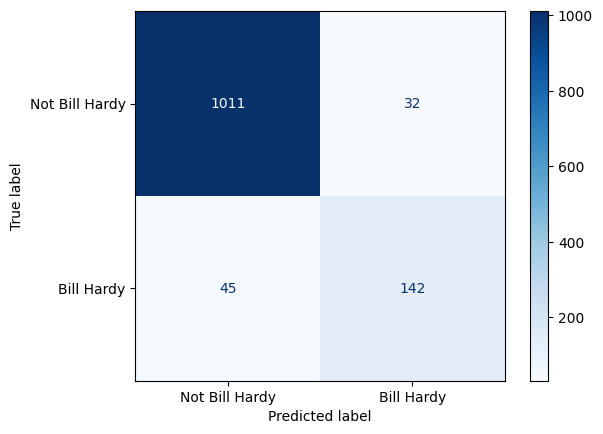

In [19]:
generate_confusion_matrix(model, df, predicted_labels)

In [20]:
identify_misclassified_items(df, predicted_labels, "sentences")

Misclassified sentences:
Expected narrator: 1 — predicted narrator: 0 — [1] But all the nice gulls love a sailor.
Expected narrator: 0 — predicted narrator: 1 — [2] London is like that; it accepts the wanderer home with a sort of warm indifference.
Expected narrator: 0 — predicted narrator: 1 — [3] My signs are a rain-proof coat, good shoes.
Expected narrator: 0 — predicted narrator: 1 — [3] No friend of mine takes his ease in my chair.
Expected narrator: 0 — predicted narrator: 1 — [3] I have no chair.
Expected narrator: 1 — predicted narrator: 0 — [4] If she had said a mashie.
Expected narrator: 0 — predicted narrator: 1 — [9] Really, if the lower orders don’t set us a good example, what on earth is the use of them?
Expected narrator: 0 — predicted narrator: 1 — [9] They seem, as a class, to have absolutely no sense of responsibility .
Expected narrator: 0 — predicted narrator: 1 — [12] It is a very ungentlemanly thing to read a private cigarette case.
Expected narrator: 1 — predicte